# Analytics Vidhya Job-a-thon November 2021

## Importing Libraries

In [171]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Survival Regression Model - Cox Proportional Hazards Model
from lifelines import CoxPHFitter 

# K-Fold Cross Validation
from lifelines.utils import k_fold_cross_validation


import warnings
warnings.filterwarnings('ignore')

## Importing Datasets

In [172]:
train_original = pd.read_csv('train_MpHjUjU.csv',parse_dates=['MMM-YY','Dateofjoining','LastWorkingDate'])
test_original = pd.read_csv('test_hXY9mYw.csv')

# Making a copy of the datasets
train = train_original.copy()
test = test_original.copy()

## Data Exploration

In [173]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Emp_ID                19104 non-null  int64         
 2   Age                   19104 non-null  int64         
 3   Gender                19104 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Salary                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Designation           19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

In [174]:
train.describe(include='all')

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104,19104.000000,19104.000000,19104,19104,19104,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
unique,24,NaN,NaN,2,29,3,NaN,869,493,NaN,NaN,NaN,NaN
top,2016-01-01 00:00:00,NaN,NaN,Male,C20,Bachelor,NaN,2012-07-23 00:00:00,2017-07-29 00:00:00,NaN,NaN,NaN,NaN
freq,1022,NaN,NaN,11103,1008,6864,NaN,192,70,NaN,NaN,NaN,NaN
first,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2010-04-01 00:00:00,2015-12-31 00:00:00,NaN,NaN,NaN,NaN
last,2017-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-28 00:00:00,2017-12-28 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,1415.591133,34.650283,NaN,NaN,NaN,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899
std,NaN,810.705321,6.264471,NaN,NaN,NaN,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832
min,NaN,1.000000,21.000000,NaN,NaN,NaN,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000
25%,NaN,710.000000,30.000000,NaN,NaN,NaN,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000


In [175]:
train.describe(include='object')

,Gender,City,Education_Level
count,19104,19104,19104
unique,2,29,3
top,Male,C20,Bachelor
freq,11103,1008,6864


In [176]:
train['Emp_ID'].unique()

array([   1,    2,    4, ..., 2786, 2787, 2788], dtype=int64)

## Data Pre-processing

In [177]:
train.groupby('Emp_ID')


In [178]:
train = train.sort_values(['MMM-YY','Emp_ID'])

In [179]:
from dateutil.relativedelta import relativedelta

# Creating next reporting date column by adding a month to the reporting date 
train['Next_Reporting_Date']= train['MMM-YY'].apply(lambda x: x + relativedelta(months=1))

In [180]:
## Creating a condition to determine the total number of working days from reporting date, joining date and last working date

# Creating a condition 
conditions2 = [(train['MMM-YY']==min(train['MMM-YY'])) & (pd.isnull(train['LastWorkingDate']))==True,
(train['MMM-YY']!=min(train['MMM-YY'])) & (pd.isnull(train['LastWorkingDate']))==True,
(train['MMM-YY']==min(train['MMM-YY'])) & (pd.notnull(train['LastWorkingDate']))==True,
(train['MMM-YY']!=min(train['MMM-YY'])) & (pd.notnull(train['LastWorkingDate']))==True]

# Creating a list of the values to assign for each condition
values2 = [(train['MMM-YY']-train['Dateofjoining']).dt.days,
(train['Next_Reporting_Date']-train['MMM-YY']).dt.days,
(train['LastWorkingDate']-train['Dateofjoining']).dt.days,
(train['LastWorkingDate']-train['MMM-YY']).dt.days]

# Creating a new column and use np.select to assign values to it using our lists as arguments
train['Days_Worked'] = np.select(conditions2, values2)
train['Days_Worked'] = train['Days_Worked'].abs()

In [181]:
## Creating a condition to determine the employee churn from last working date
conditions3 = [pd.notnull(train['LastWorkingDate'])==True,pd.notnull(train['LastWorkingDate'])==False]

# Create a list of the values to assign for each condition
values3 = [1,0]

# Creating a new column and use np.select to assign values to it using our lists as argument
train['Attrition'] = np.select(conditions3, values3)

In [182]:
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating,Next_Reporting_Date,Days_Worked,Attrition
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,2016-02-01,8.0,0
10,2016-01-01,5,29,Male,C9,College,46368,2016-01-09,NaT,1,1,0,1,2016-02-01,8.0,0
28,2016-01-01,13,29,Male,C19,Master,119227,2012-05-28,NaT,1,4,250000,1,2016-02-01,1313.0,0
54,2016-01-01,16,30,Female,C23,College,52963,2015-11-30,NaT,2,2,346800,1,2016-02-01,32.0,0
56,2016-01-01,17,42,Male,C20,Master,51099,2015-03-06,NaT,1,1,100000,2,2016-02-01,301.0,0


In [183]:
train['Attrition'].unique()

array([0, 1])

In [184]:
# Creating a new dataframe by grouping Emp_ID
new_train = (train.groupby(['Emp_ID'],as_index=False).agg({'Age':'max','Gender':'first','City':'first','Education_Level':'first',
'Salary':'max','Joining Designation':'min','Designation':'max','Total Business Value':'sum',
'Quarterly Rating':'mean','Days_Worked':'sum','Attrition':'sum'}))

### Encoding Categorical Variables

In [185]:
categorical_cols = new_train.select_dtypes(include=['object'])
for col in categorical_cols:
    print(col,new_train[col].unique())

Gender ['Male' 'Female']
City ['C23' 'C7' 'C13' 'C9' 'C11' 'C2' 'C19' 'C26' 'C20' 'C17' 'C29' 'C10'
 'C24' 'C14' 'C6' 'C28' 'C5' 'C18' 'C27' 'C15' 'C8' 'C25' 'C21' 'C1' 'C4'
 'C3' 'C16' 'C22' 'C12']
Education_Level ['Master' 'College' 'Bachelor']


In [186]:
# Creating a new dataframe
new_train2 = new_train.copy()

In [187]:
# Encoding nominal variables with high cardinality

# Grouping by frequency
fq = new_train.groupby('City').size()/len(new_train)  

# Mapping values to dataframe
new_train.loc[:, "{}_freq_encode".format('City')] = new_train['City'].map(fq)  

# Dropping the original column.
new_train = new_train.drop(['City'], axis = 1)

In [188]:
# Encoding nominal variables with few classes
new_train = pd.get_dummies(new_train,columns = ['Gender'], drop_first=True)

In [189]:
# Encoding ordinal variable
from pandas.api.types import CategoricalDtype
new_train['Education_Level'] = new_train['Education_Level'].astype(CategoricalDtype(categories=['College','Bachelor','Master'],ordered=True)).cat.codes

### Merging Rows from new_train dataset into test dataset

In [190]:
new_test = pd.merge(test,new_train, on='Emp_ID')

In [191]:
## Removing test observations from the train dataset

# Getting values of index
train_index = new_train.index
test_index = new_test.index

# Determining rows that are not common in train and test datasets
mask = ~train_index.isin(test_index)
new_train = new_train.loc[mask]


In [192]:
# Dropping 'Emp_ID' from train and test datasets
new_train.drop('Emp_ID', axis=1, inplace=True)
new_test.drop('Emp_ID', axis=1, inplace=True)

## Survival Analysis

### Kaplan Meier Curves for Analysis 

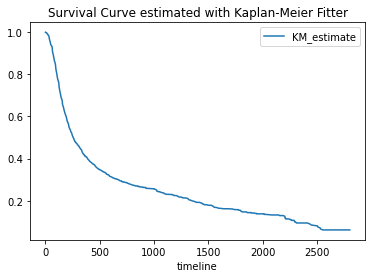

In [193]:
from lifelines import KaplanMeierFitter# Initiate and fit

# Time to event data of censored and event data
durations = new_train['Days_Worked']

# The variables has values: churned(1), censored(0)
event_observed = new_train['Attrition'] 

# Creating a kmf object as km
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(durations=new_train.Days_Worked, event_observed=new_train.Attrition)# Plot the survival function

#  Create an estimate
kmf.survival_function_.plot()
plt.title('Survival Curve estimated with Kaplan-Meier Fitter')
plt.show()

In [194]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,1640,1640
1.0,1,1,0,0,1640
4.0,1,1,0,0,1639
9.0,1,1,0,0,1638
11.0,3,3,0,0,1637
...,...,...,...,...,...
2634.0,1,0,1,0,5
2703.0,1,0,1,0,4
2739.0,1,0,1,0,3


In [195]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.999390
4.0,0.998780
9.0,0.998171
11.0,0.996341
...,...
2634.0,0.061247
2703.0,0.061247
2739.0,0.061247


#### Kaplan Meier Curves for Cohorts

<AxesSubplot:xlabel='timeline'>

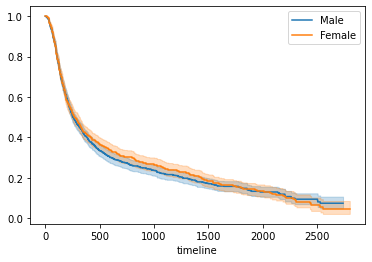

In [196]:
## 1. Kaplan Meier Curves for Gender Cohorts
kmf1 = KaplanMeierFitter() 

T = new_train2['Days_Worked']
E = new_train2['Attrition']

## Two Cohorts are compared. 1. Male Employees, 2.Female Employees
groups = new_train2['Gender'] 
i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Male')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Female')
kmf1.plot(ax=a1)

<AxesSubplot:xlabel='timeline'>

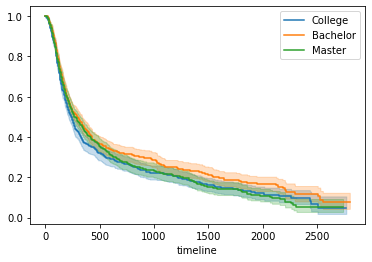

In [197]:
## 2. Kaplan Meier Curves for Education Education Level Cohorts
kmf1 = KaplanMeierFitter() 

T = new_train2['Days_Worked']
E = new_train2['Attrition']

# Three cohorts are compared. 1. Employees With College Education, 2.Employees with bachelor level education, 3. Employees with master's
groups = new_train2['Education_Level'] 
i1 = (groups == 'College')      # group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Bachelor')    # group i2 , having the pandas series for the 2nd cohort
i3 = (groups == 'Master')    # group i3 , having the pandas series for the 3rd cohort


# fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='College')
a1 = kmf1.plot()

# fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Bachelor')
kmf1.plot(ax=a1)

# fit the model for 3rd cohort
kmf1.fit(T[i3], E[i3], label='Master')
kmf1.plot(ax=a1)


kmf = KaplanMeierFitter()
kmf.fit(durations=new_train.Half_Yearly, event_observed=new_train.Attrition)# Plot the survival function
kmf.survival_function_.plot()
plt.title('Survival Curve estimated with Kaplan-Meier Fitter')
plt.show()

### Cox Proportional Hazards model

In [198]:
## 1. Model with all variables
from lifelines import CoxPHFitter 
cph = CoxPHFitter() 

cph_scores = k_fold_cross_validation(cph, new_train, 'Days_Worked', event_col='Attrition', k=5,scoring_method='concordance_index')
print(cph_scores)

# Fitting the data to train the model
cph.fit(new_train, 'Days_Worked', event_col='Attrition')   
  
# Checking significance of the features
cph.print_summary()    

[0.8134600364488415, 0.8275870842981095, 0.8116784630940344, 0.8307012813599364, 0.8187854547355763]


<lifelines.CoxPHFitter: fitted with 1640 total observations, 508 right-censored observations>
             duration col = 'Days_Worked'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1640
number of events observed = 1132
   partial log-likelihood = -6704.82
         time fit was run = 2021-11-21 13:41:56 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Age                   -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
Education_Level       -0.08       0.93       0.04            -0.15            -0.00                 0.86                 1.00
Salary                -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Joining Designation    0.80       2.22       0.08             0.65             0.94                 1.91                 2.57
Designation           -0.84       0.43       0.08            -1.00            -0.68                 0.37                 0.51
Total Business Value  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Quarterly Rating      -0.80       0.45       0.09            -0.98            -0.62                 0.37                 0.54
City_freq_encode      -2.33       0.10       3.54            -9.27             4.61                 0.00               100.17
Gender_Male           -0.05       0.95       0.06            -0.17             0.07                 0.85                 1.08

                          z      p   -log2(p)
covariate                                    
Age                   -4.78 <0.005      19.10
Education_Level       -2.00   0.05       4.46
Salary                -0.69   0.49       1.03
Joining Designation   10.57 <0.005      84.28
Designation          -10.25 <0.005      79.51
Total Business Value  -8.77 <0.005      58.93
Quarterly Rating      -8.68 <0.005      57.86
City_freq_encode      -0.66   0.51       0.97
Gender_Male           -0.76   0.44       1.17
---
Concordance = 0.82
Partial AIC = 13427.65
log-likelihood ratio test = 1411.13 on 9 df
-log2(p) of ll-ratio test = 988.33

<AxesSubplot:xlabel='log(HR) (95% CI)'>

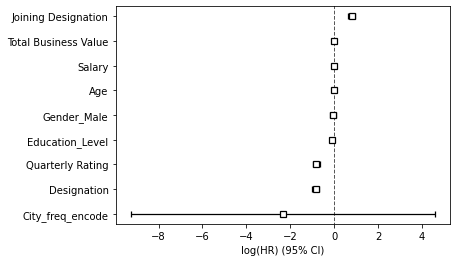

In [199]:
# Forest Plot for Covariates
cph.plot()

In [200]:
## 2. Model after removing insignificant variables

X_train = new_train.drop(['City_freq_encode','Gender_Male','Salary'], axis = 1)
X_test = new_test.drop(['City_freq_encode','Gender_Male','Salary'], axis = 1)

cph2 = CoxPHFitter() 

cph_scores2 = k_fold_cross_validation(cph2, X_train, 'Days_Worked', event_col='Attrition', k=5,scoring_method='concordance_index')
print(cph_scores2)

# Fitting the data to train the model
cph2.fit(X_train, 'Days_Worked', event_col='Attrition')   
  
# Checking significance of the features
cph2.print_summary()

[0.8274663588909582, 0.8276166234028075, 0.8252950752950753, 0.8165135253390986, 0.811755991058897]


<lifelines.CoxPHFitter: fitted with 1640 total observations, 508 right-censored observations>
             duration col = 'Days_Worked'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1640
number of events observed = 1132
   partial log-likelihood = -6705.58
         time fit was run = 2021-11-21 13:41:59 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
Age                   -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.99
Education_Level       -0.08       0.92       0.04            -0.15            -0.01                 0.86                 0.99
Joining Designation    0.79       2.19       0.07             0.64             0.93                 1.89                 2.54
Designation           -0.86       0.42       0.07            -1.00            -0.72                 0.37                 0.49
Total Business Value  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Quarterly Rating      -0.81       0.45       0.09            -0.99            -0.63                 0.37                 0.53

                          z      p   -log2(p)
covariate                                    
Age                   -4.76 <0.005      19.01
Education_Level       -2.27   0.02       5.43
Joining Designation   10.50 <0.005      83.31
Designation          -11.76 <0.005     103.58
Total Business Value  -8.79 <0.005      59.15
Quarterly Rating      -8.78 <0.005      59.08
---
Concordance = 0.82
Partial AIC = 13423.16
log-likelihood ratio test = 1409.61 on 6 df
-log2(p) of ll-ratio test = 998.89

<AxesSubplot:xlabel='log(HR) (95% CI)'>

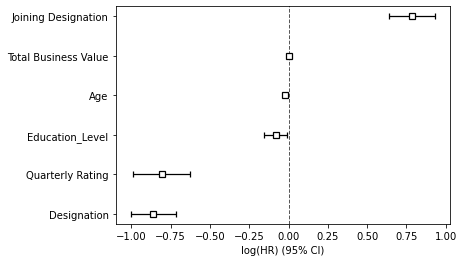

In [201]:
# Forest Plot for Covariates
cph2.plot()

In [202]:
# Comparing scores of first model and second model
print(cph.score(new_train,scoring_method="concordance_index"))
print(cph2.score(X_train,scoring_method="concordance_index"))

0.8245907894547894
0.8230163109815514


Although the Concordance Index of the first model is higher, the model with only significant variables is more stable considering the cross validation scores.
we will be selecting the second model (model with only significant covariates) for prediction of churn.

Survival function is the probability of survival beyond a specific period of time. We can use survival function to predict which of the employees leave the companies within the first 6 months of 2018.

In [203]:
# Predicting the survival function
cph2_survival_func = cph2.predict_survival_function(new_test)

# Transposing the dataframe
cph2_survival_func = pd.DataFrame(cph2_survival_func).transpose()

# Selecting the predicted survival function values for 181st day (the prediction period for churn is 6 months)
cph2_survival_func = cph2_survival_func[180.0]

In [204]:
cph2_survival_func

0      0.997594
1      0.995910
2      0.999907
3      0.993557
4      0.999983
         ...   
736    0.999989
737    0.998798
738    0.998291
739    0.998456
740    0.986600
Name: 180.0, Length: 741, dtype: float64

We must predict if an employee will leave the company from 01-01-2018 to 01-07-2018 i.e. 181 days. 
If the survival function on 181st day is more than 0.5, then the employee will stay in the company longer than 6 months. If it is less than 0.5, he/she is more likely to leave.

In [205]:
## Creating a condition to derive Target (attrition) from predicted survival function

# Creating a condition to assign values to target variable based on survival function
conditions4 = [cph2_survival_func <0.5,cph2_survival_func >=0.5]
values4 = [1,0]

### Adding Predicted Values to the Submission File

In [206]:
submission = pd.read_csv('sample_submission.csv')
submission['Target'] = np.select(conditions4, values4)
submission.to_csv('sample_submission.csv', index=False)